In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys

sys.path.insert(0, "..\\..\\..\\")
from frxas import time_domain, hdf5_io

# Start by simulating data

In [2]:
f = 0.5  # frequency
wfm = 200  # Number of waveforms
phs_v = -85 * np.pi / 180  # phase angle of voltage, converted to radians
phs_j = -66 * np.pi / 180  # phase angle of current, converted to radians

w = 2 * np.pi * f  # radial frequency
fs = 50 * f  # sampling rate
t_end = wfm / f  # ending time
ns = int(fs * t_end)  # number of samples

t = np.linspace(0, t_end - 1 / fs, num=ns)  # time array
v = 0.1 * np.cos(w * t + phs_v)
j = (
    0.08 * np.cos(w * t + phs_j)
    + 1e-2 * np.cos(2 * (w * t + phs_j))
    + 5e-3 * np.cos(3 * (w * t + phs_j))
)

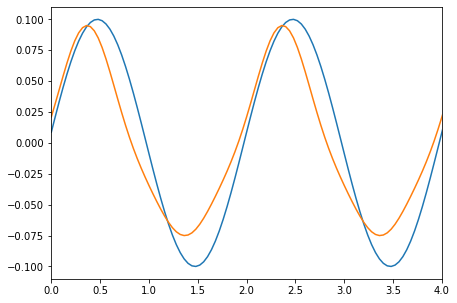

In [3]:
_, ax = plt.subplots(figsize=(7, 5))

ax.plot(t, v)
ax.plot(t, j)

ax.set_xlim(0, 4)
plt.show()

#### Now use frxas.py to extract real and imaginary components, and phase align signals

In [4]:
b = 0.1 * wfm

_, j_fit = time_domain.phase_align(t, v, j, f, b, phase=0, harmonics=3)
_, v_fit = time_domain.phase_align(t, v, v, f, b, phase=0, harmonics=1)

#### Compare the magnitude and phases of v and j to what we input above

In [5]:
print(f"V Magnitude: {np.abs(v_fit.params['h1_re_comp'] + 1j * v_fit.params['h1_im_comp'])}")
print(
    f"V Phase: {np.angle(v_fit.params['h1_re_comp'] + 1j * v_fit.params['h1_im_comp'], deg=True)}"
)

print(f"J Magnitude: {np.abs(j_fit.params['h1_re_comp'] + 1j * j_fit.params['h1_im_comp'])}")
print(
    f"J Phase: {np.angle(j_fit.params['h1_re_comp'] + 1j * j_fit.params['h1_im_comp'], deg=True)}"
)

V Magnitude: 0.10000020580419243
V Phase: 0.0
J Magnitude: 0.08000385523124283
J Phase: 19.00460323898577


#### We see the magnitudes are spot on! And the relative phase between the signals is recovered, though it has been changed from 90 degrees (sine wave) to 0 degrees (cosine). 

#### We can calculate the impedance from our fit fourier coefficients

In [6]:
(v_fit.params["h1_re_comp"] + 1j * v_fit.params["h1_im_comp"]) / (
    j_fit.params["h1_re_comp"] + 1j * j_fit.params["h1_im_comp"]
)

(1.1818110002156774-0.4070363699373282j)

#### We can see all of the fit coefficients by examining the lmfit.model variables

In [7]:
v_fit

In [8]:
j_fit

# Now let's show what is happening under the hood of phase_align()

#### First, it finds the signal length and calculates the frequency list

In [9]:
from numpy import fft

ns = np.size(t)
freqs = fft.fftshift(fft.fftfreq(ns, t[1]))

#### Then it applies the gaussian windowing function and calculates the FFT of the reference and signal data. "Reference" is the data we phase align the "signal" data to. 

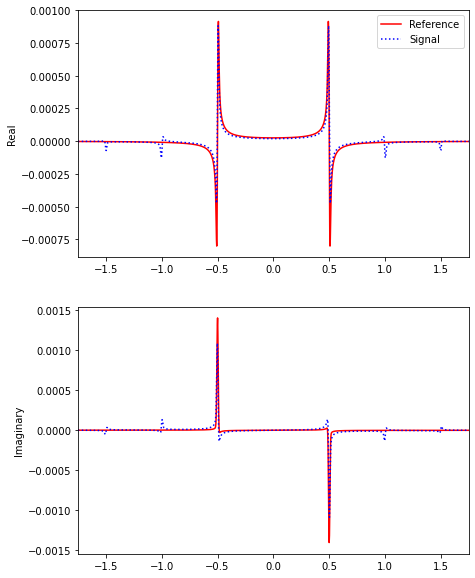

In [10]:
reference = v
signal = j

ref_fft = time_domain.get_windowed_fft(t, reference, f, b)
sig_fft = time_domain.get_windowed_fft(t, signal, f, b)

_, axes = plt.subplots(nrows=2, figsize=(7, 10))

axes[0].plot(freqs, ref_fft.real, "r-", label="Reference")
axes[0].plot(freqs, sig_fft.real, "b:", label="Signal")
axes[0].set_ylabel("Real")
axes[0].legend()

axes[1].plot(freqs, ref_fft.imag, "r-")
axes[1].plot(freqs, sig_fft.imag, "b:")
axes[1].set_ylabel("Imaginary")

for ax in axes:
    ax.set_xlim(-3.5 * f, 3.5 * f)

plt.show()

#### The FFTs are fit to the following lineshape constructed of Gaussian and Dawson functions defined by 

$$
\hat{V}(\omega)=\frac{1}{2} \sum_{k=0}^{\infty} \hat{V^{'}_k} (G_k(\omega) + G_{-k}(\omega)) + \hat{V^{''}_k} (D_k(\omega) - D_{-k}(\omega))
+ \frac{j}{2} \sum_{k=0}^{\infty} \hat{V^{''}_k} (G_k(\omega)
- G_{-k}(\omega)) + \hat{V^{'}_k} (-D_k(\omega) - D_{-k}(\omega))
$$

#### where:
$$
G_k(\omega)=\frac{b\sqrt{\pi}}{\tilde{\omega}}exp(\frac{-((\omega-k
\tilde{\omega})\pi b)^2}{\tilde{\omega}^2})
$$
$$
G_{-k}(\omega)=\frac{b\sqrt{\pi}}{\tilde{\omega}}exp(\frac{-((\omega+k
\tilde{\omega})\pi b)^2}{\tilde{\omega}^2})
$$
$$
D_{k}(\omega)=\frac{b\sqrt{\pi}}{\tilde{\omega}}exp(\frac{-((\omega-k
\tilde{\omega})\pi b)^2}{\tilde{\omega}^2})erfi(\frac{(\omega-k
\tilde{\omega})\pi b}{\tilde{\omega}})
$$
$$
D_{-k}(\omega)=\frac{b\sqrt{\pi}}{\tilde{\omega}}exp(\frac{-((\omega+k
\tilde{\omega})\pi b)^2}{\tilde{\omega}^2})erfi(\frac{(\omega+k
\tilde{\omega})\pi b}{\tilde{\omega}})
$$

#### This lineshape is duplicated for each harmonic being fit and they are summed together, much like peak-fitting in XPS

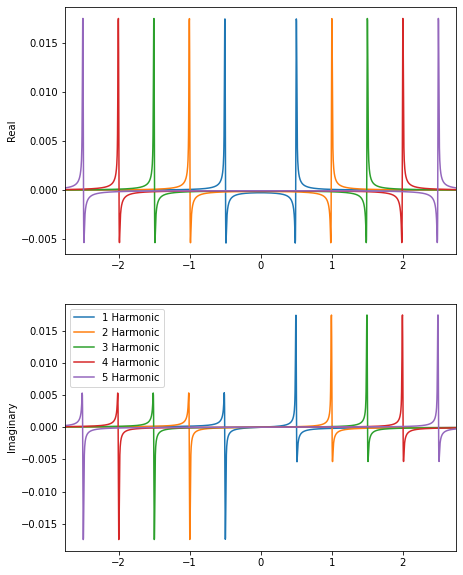

In [11]:
lines = []
k = 5

for i in np.arange(1, k + 1):
    lines.append(time_domain.fft_shape(freqs, f, b, harmonic=i))

_, axes = plt.subplots(nrows=2, figsize=(7, 10))

for i, line in enumerate(lines):
    axes[0].plot(freqs, line.real)
    axes[1].plot(freqs, line.imag, label=f"{i+1} Harmonic")
axes[0].set_ylabel("Real")
axes[1].legend()
axes[1].set_ylabel("Imaginary")

for ax in axes:
    ax.set_xlim(-5.5 * f, 5.5 * f)

plt.show()

### Fitting the data means we are finding $ \hat{V^{'}_k} $ and $ \hat{V^{''}_k} $

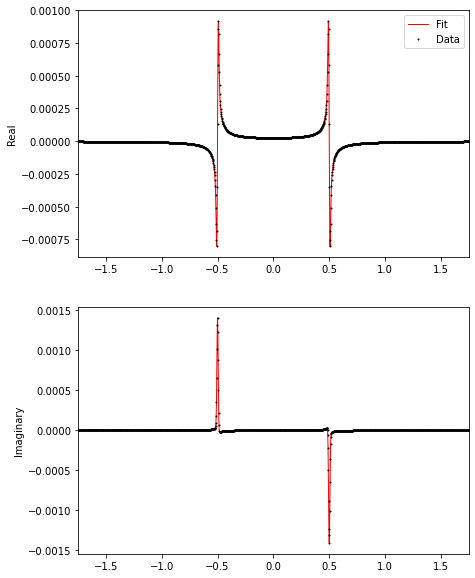

In [12]:
ref_fit = time_domain.fit_windowed_fft(freqs, ref_fft, f, b, harmonics=3)

_, axes = plt.subplots(nrows=2, figsize=(7, 10))

axes[0].plot(freqs, ref_fit.eval().real, "r-", lw=1, label="Fit")
axes[0].plot(freqs, ref_fft.real, "k.", ms=2, label="Data")
axes[0].set_ylabel("Real")
axes[0].legend()

axes[1].plot(freqs, ref_fit.eval().imag, "r-", lw=1)
axes[1].plot(freqs, ref_fft.imag, "k.", ms=2)
axes[1].set_ylabel("Imaginary")

for ax in axes:
    ax.set_xlim(-3.5 * f, 3.5 * f)

plt.show()

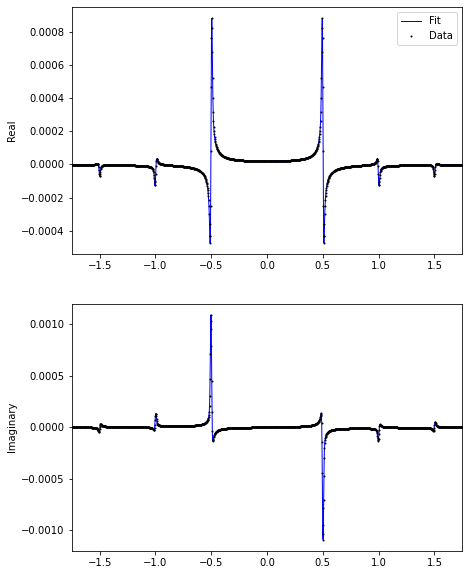

In [13]:
sig_fit = time_domain.fit_windowed_fft(freqs, sig_fft, f, b, harmonics=3)

_, axes = plt.subplots(nrows=2, figsize=(7, 10))

axes[0].plot(freqs, sig_fit.eval().real, "b-", lw=1, label="Fit")
axes[0].plot(freqs, sig_fft.real, "k.", ms=2, label="Data")
axes[0].set_ylabel("Real")
axes[0].legend()

axes[1].plot(freqs, sig_fit.eval().imag, "b-", lw=1)
axes[1].plot(freqs, sig_fft.imag, "k.", ms=2)
axes[1].set_ylabel("Imaginary")

for ax in axes:
    ax.set_xlim(-3.5 * f, 3.5 * f)

plt.show()

#### Finally, the "signal" coefficients are aligned to a phase angle given by the user, while maintaining phase coherence with the "reference"

In [14]:
phase = 0
harmonics = 3

ref_comps = {}
sig_comps = {}

for i in range(1, harmonics + 1):
    ref_comps[f"ang_{i}"] = np.angle(
        ref_fit.params[f"h{i}_re_comp"].value + 1j * ref_fit.params[f"h{i}_im_comp"].value
    )
    ref_comps[f"mag_{i}"] = np.abs(
        ref_fit.params[f"h{i}_re_comp"].value + 1j * ref_fit.params[f"h{i}_im_comp"].value
    )
    sig_comps[f"ang_{i}"] = np.angle(
        sig_fit.params[f"h{i}_re_comp"].value + 1j * sig_fit.params[f"h{i}_im_comp"].value
    )
    sig_comps[f"mag_{i}"] = np.abs(
        sig_fit.params[f"h{i}_re_comp"].value + 1j * sig_fit.params[f"h{i}_im_comp"].value
    )

# Desired phase angle to radians and find adjustment factor
phs = phase * np.pi / 180
ang_adj = phs - ref_comps["ang_1"]

# Adjust real an imag component of each harmonic by adjustment factor
# times harmonic index

for i in range(1, harmonics + 1):
    ref_fit.params[f"h{i}_re_comp"].value = (
        np.cos(ref_comps[f"ang_{i}"] + ang_adj * i) * ref_comps[f"mag_{i}"]
    )
    ref_fit.params[f"h{i}_im_comp"].value = (
        np.sin(ref_comps[f"ang_{i}"] + ang_adj * i) * ref_comps[f"mag_{i}"]
    )
    sig_fit.params[f"h{i}_re_comp"].value = (
        np.cos(sig_comps[f"ang_{i}"] + ang_adj * i) * sig_comps[f"mag_{i}"]
    )
    sig_fit.params[f"h{i}_im_comp"].value = (
        np.sin(sig_comps[f"ang_{i}"] + ang_adj * i) * sig_comps[f"mag_{i}"]
    )

#### This directly modifies the fourier coefficients in the lmfit.model object, so the fit FFT now looks very different from the data

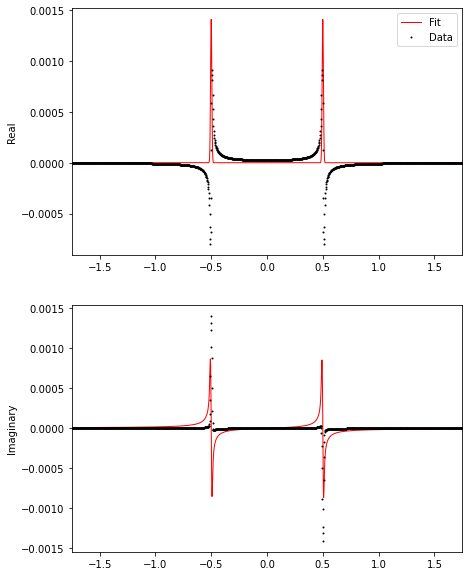

In [15]:
_, axes = plt.subplots(nrows=2, figsize=(7, 10))

axes[0].plot(freqs, ref_fit.eval().real, "r-", lw=1, label="Fit")
axes[0].plot(freqs, ref_fft.real, "k.", ms=2, label="Data")
axes[0].set_ylabel("Real")
axes[0].legend()

axes[1].plot(freqs, ref_fit.eval().imag, "r-", lw=1)
axes[1].plot(freqs, ref_fft.imag, "k.", ms=2)
axes[1].set_ylabel("Imaginary")

for ax in axes:
    ax.set_xlim(-3.5 * f, 3.5 * f)

plt.show()

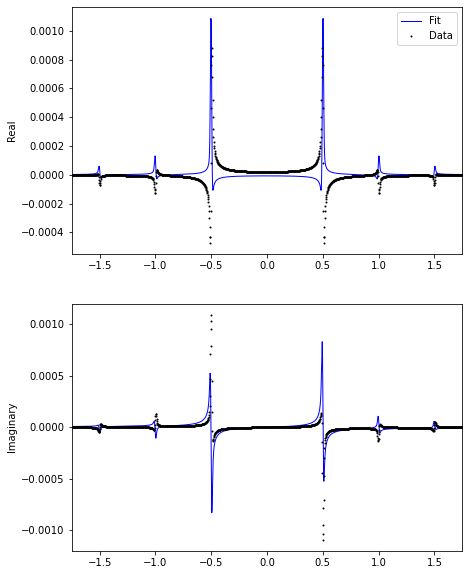

In [16]:
_, axes = plt.subplots(nrows=2, figsize=(7, 10))

axes[0].plot(freqs, sig_fit.eval().real, "b-", lw=1, label="Fit")
axes[0].plot(freqs, sig_fft.real, "k.", ms=2, label="Data")
axes[0].set_ylabel("Real")
axes[0].legend()

axes[1].plot(freqs, sig_fit.eval().imag, "b-", lw=1)
axes[1].plot(freqs, sig_fft.imag, "k.", ms=2)
axes[1].set_ylabel("Imaginary")

for ax in axes:
    ax.set_xlim(-3.5 * f, 3.5 * f)

plt.show()

#### But if we regenerate our synthetic data at the target phase angle, with the same phase difference, we'll see the fit FFTs agree quite well

In [17]:
phs_j2 = 19 * np.pi / 180
v2 = 0.1 * np.cos(w * t)
j2 = (
    0.08 * np.cos(w * t + phs_j2)
    + 1e-2 * np.cos(2 * (w * t + phs_j2))
    + 5e-3 * np.cos(3 * (w * t + phs_j2))
)

ref_fft2 = time_domain.get_windowed_fft(t, v2, f, b)
sig_fft2 = time_domain.get_windowed_fft(t, j2, f, b)

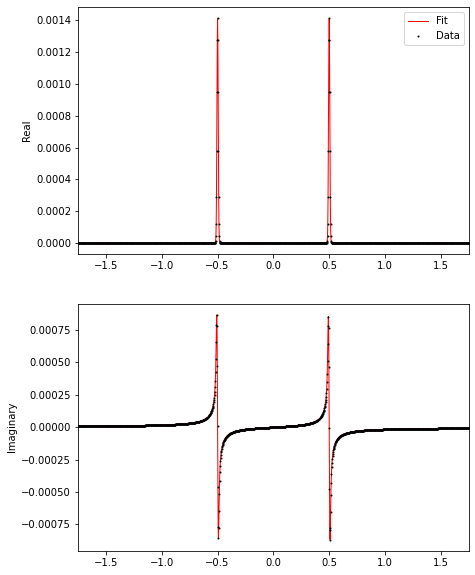

In [18]:
_, axes = plt.subplots(nrows=2, figsize=(7, 10))

axes[0].plot(freqs, ref_fit.eval().real, "r-", lw=1, label="Fit")
axes[0].plot(freqs, ref_fft2.real, "k.", ms=2, label="Data")
axes[0].set_ylabel("Real")
axes[0].legend()

axes[1].plot(freqs, ref_fit.eval().imag, "r-", lw=1)
axes[1].plot(freqs, ref_fft2.imag, "k.", ms=2)
axes[1].set_ylabel("Imaginary")

for ax in axes:
    ax.set_xlim(-3.5 * f, 3.5 * f)

plt.show()

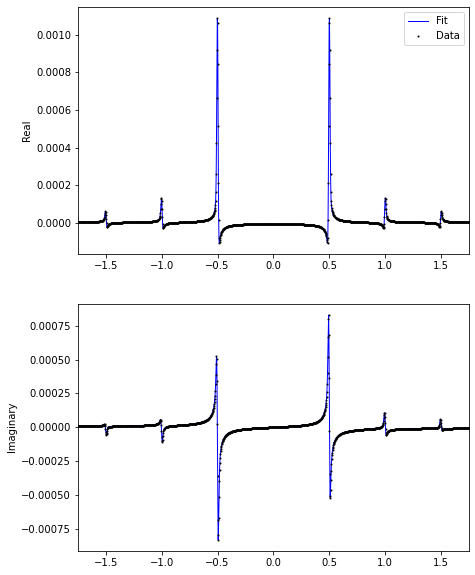

In [19]:
_, axes = plt.subplots(nrows=2, figsize=(7, 10))

axes[0].plot(freqs, sig_fit.eval().real, "b-", lw=1, label="Fit")
axes[0].plot(freqs, sig_fft2.real, "k.", ms=2, label="Data")
axes[0].set_ylabel("Real")
axes[0].legend()

axes[1].plot(freqs, sig_fit.eval().imag, "b-", lw=1)
axes[1].plot(freqs, sig_fft2.imag, "k.", ms=2)
axes[1].set_ylabel("Imaginary")

for ax in axes:
    ax.set_xlim(-3.5 * f, 3.5 * f)

plt.show()